In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tqdm

In [3]:
import pandas as pd

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
import pickle

In [6]:
with open("atoms_train.pckl","rb") as f:
    train_se=pickle.load(f)

with open("atoms_test.pckl","rb") as f:
    test_se=pickle.load(f)

In [7]:
from helper_repr import *

In [8]:
additional_columns=['percent_atom_al',
 'percent_atom_ga',
 'percent_atom_in',
 'lattice_vector_1_ang',
 'lattice_vector_2_ang',
 'lattice_vector_3_ang',
 'number_of_total_atoms',
 'lattice_angle_beta_degree',
 'lattice_angle_alpha_degree',
 'lattice_angle_gamma_degree']

In [9]:
for col in additional_columns:
    for atoms in train_se:
        id=atoms._VALUE["id"]
        atoms._VALUE[col]=X_train.loc[id-1][col]

In [10]:
for col in additional_columns:
    for atoms in test_se:
        id=atoms._VALUE["id"]
        atoms._VALUE[col]=X_test.loc[id-1][col]

In [11]:
vector_desc_to_include=['mu_sp_orig','an_sp', 'bn_sp']
scalar_desc_to_include=["volume_sp"]

In [12]:
scalar_desc_to_include+=[
    'EA_ave_std', 'IP_ave_std', 'EA_ave_mean', 'EA_diff_std', 'IP_ave_mean',
    'IP_diff_std', 'EA_diff_mean', 'HOMO_ave_std', 'IP_diff_mean',
    'LUMO_ave_std', 'mass_ave_std', 'HOMO_ave_mean', 'HOMO_diff_std',
    'LUMO_ave_mean', 'LUMO_diff_std', 'mass_ave_mean', 'mass_diff_std',
    'HOMO_diff_mean', 'LUMO_diff_mean', 'mass_diff_mean', 'period_ave_std',
    'rd_max_ave_std', 'rp_max_ave_std', 'rs_max_ave_std', 'percent_atom_al',
    'percent_atom_ga', 'percent_atom_in', 'period_ave_mean', 'period_diff_std',
    'rd_max_ave_mean', 'rd_max_diff_std', 'rp_max_ave_mean', 'rp_max_diff_std',
    'rs_max_ave_mean', 'rs_max_diff_std', 'period_diff_mean',
    'rd_max_diff_mean', 'rp_max_diff_mean', 'rs_max_diff_mean',
     'vdw_radius_ave_std', 'vdw_radius_ave_mean',
    'vdw_radius_diff_std', 'lattice_vector_1_ang', 'lattice_vector_2_ang',
    'lattice_vector_3_ang', 'vdw_radius_diff_mean', 'atomic_volume_ave_std',
    'number_of_total_atoms', 'atomic_volume_ave_mean',
    'atomic_volume_diff_std', 'atomic_volume_diff_mean',
    'covalent_radius_ave_std', 'covalent_radius_ave_mean',
    'covalent_radius_diff_std', 'covalent_radius_diff_mean',
    'electron_affinity_ave_std', 'electronegativity_ave_std',
     'heat_of_formation_ave_std',
    'lattice_angle_beta_degree', 'atomic_radius_rahm_ave_std',
    'electron_affinity_ave_mean', 'electron_affinity_diff_std',
    'electronegativity_ave_mean', 'electronegativity_diff_std',
    'heat_of_formation_ave_mean', 'heat_of_formation_diff_std',
    'lattice_angle_alpha_degree', 'lattice_angle_gamma_degree',
    'atomic_radius_rahm_ave_mean', 'atomic_radius_rahm_diff_std',
    'electron_affinity_diff_mean', 'electronegativity_diff_mean',
    'heat_of_formation_diff_mean', 'atomic_radius_rahm_diff_mean',
    'dipole_polarizability_ave_std', 'dipole_polarizability_ave_mean',
    'dipole_polarizability_diff_std', 'dipole_polarizability_diff_mean'
]

In [15]:
se=train_se[0]

In [16]:
tot_col_names=[col_name+"_"+str(i) for col_name in vector_desc_to_include for i in range(0,len(se._VALUE[col_name][0]))]
tot_col_names+=scalar_desc_to_include

len(tot_col_names)


117

In [17]:
tot_df_train = pd.DataFrame()
dfs=[tot_df_train]

for se in tqdm.tqdm_notebook(train_se):
    df=pd.DataFrame(np.hstack(
        [se._VALUE[desc_name] for desc_name in vector_desc_to_include]
        ))

    for desc in scalar_desc_to_include:
        df[desc] = se._VALUE[desc]
    df["id"]=se._VALUE["id"]
    df["occ"]=se.get_chemical_symbols()
    dfs.append(df)

In [18]:
tot_df_train=pd.concat(dfs)
indices_and_occupation_df_train=tot_df_train[["id","occ"]]
tot_df_train=tot_df_train.drop(["id","occ"],axis=1)

In [19]:
tot_df_test = pd.DataFrame()
dfs=[tot_df_test]
for se in tqdm.tqdm_notebook(test_se):
    df=pd.DataFrame(np.hstack(
        [se._VALUE[desc_name] for desc_name in vector_desc_to_include]
        ))

    for desc in scalar_desc_to_include:
        df[desc] = se._VALUE[desc]
    df["id"]=se._VALUE["id"]
    df["occ"]=se.get_chemical_symbols()
    dfs.append(df)
    
tot_df_test=pd.concat(dfs)
indices_and_occupation_df_test=tot_df_test[["id","occ"]]
tot_df_test=tot_df_test.drop(["id","occ"],axis=1)

In [23]:
tot_df_train.columns = tot_col_names
tot_df_test.columns = tot_col_names

In [24]:
tot_df_train.shape

(148030, 117)

In [25]:
tot_df_test.shape

(37040, 117)

In [26]:
train_len=len(tot_df_train)
test_len=len(tot_df_test)

In [28]:
tot_df=pd.concat([tot_df_train,tot_df_test],axis=0) # use structures from train and test for clustering
indices_and_occupation_df=pd.concat([indices_and_occupation_df_train,indices_and_occupation_df_test],axis=0)

# Atomic environment clustering

In [29]:
import seaborn as sns

In [30]:
from mpl_toolkits.mplot3d import Axes3D

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

In [32]:
occ_dict={"Al":0,"Ga":1,"In":2,"O":4}

In [33]:
X_col="an_sp_1"
Y_col="bn_sp_2"
Z_col="volume_sp"

In [34]:
temp_df =pd.concat([tot_df,indices_and_occupation_df],axis=1)

In [35]:
temp_df["occ_id"]=temp_df["occ"].map(occ_dict)

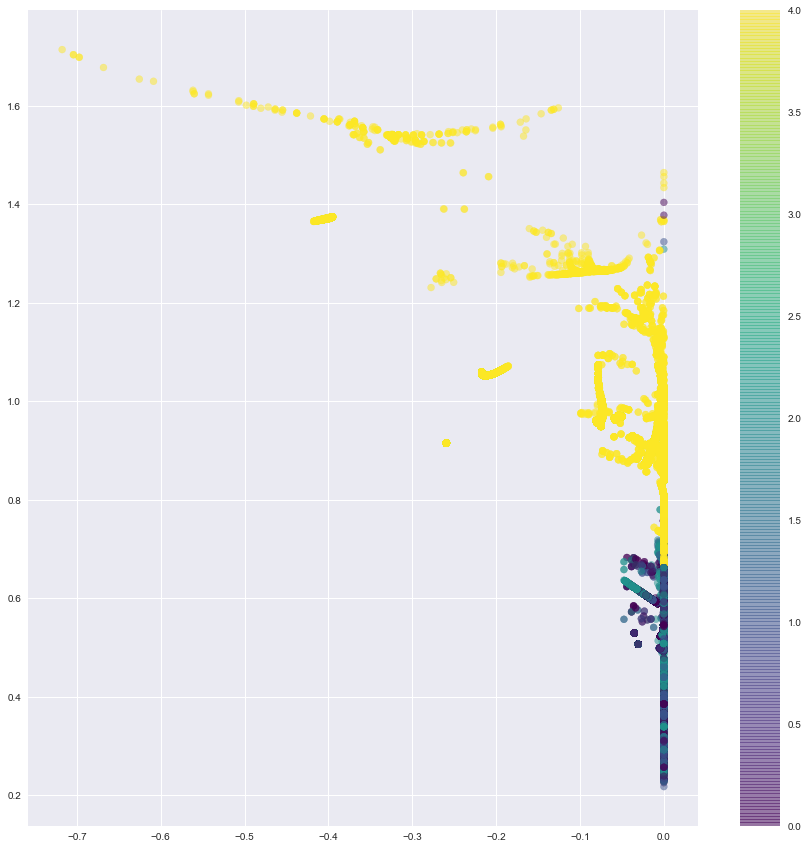

In [36]:
plt.figure(figsize=(15,15))
plt.scatter(temp_df[X_col],temp_df[Y_col],c=temp_df["occ_id"],cmap="viridis",alpha=0.5)
plt.colorbar()

## Oxygen structure map clustering

In [37]:
temp_df_O = temp_df[temp_df.occ=="O"]

In [38]:
n_clusters_O = 7

!!! Unfortunately, `random_state` was not fixed for this clustering. So, order of cluster labels could not corespond to the cluster labels in final submission. 
Original data, used in feature selection, model hyperoptimization and final submission are stored in `X_moments_atomic_train.csv` and  `X_moments_atomic_test.csv`.

In [39]:
clustering_pipeline=make_pipeline(StandardScaler(), KMeans(n_clusters=n_clusters_O,random_state=16))

In [40]:
df_to_draw = temp_df_O

In [41]:
labels_O=clustering_pipeline.fit_predict(df_to_draw[[X_col,Y_col,Z_col]])

In [42]:
len(labels_O)

111042

## Metal structure map clustering

In [43]:
temp_df_Me = temp_df[temp_df.occ!="O"]

In [44]:
temp_df_Me.shape

(74028, 120)

In [45]:
temp_df_Me.shape

(74028, 120)

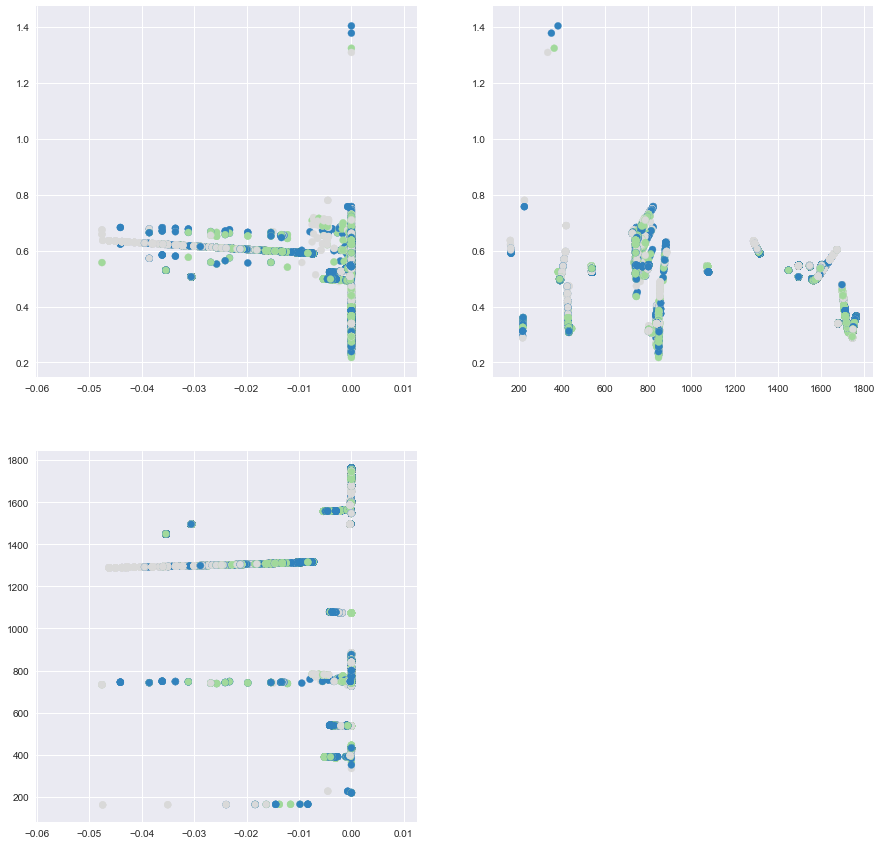

In [46]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.scatter(temp_df_Me[X_col],temp_df_Me[Y_col],c=temp_df_Me["occ_id"],cmap="tab20c",alpha=1)

plt.subplot(222)
plt.scatter(temp_df_Me[Z_col],temp_df_Me[Y_col],c=temp_df_Me["occ_id"],cmap="tab20c",alpha=1)

plt.subplot(223)
plt.scatter(temp_df_Me[X_col],temp_df_Me[Z_col],c=temp_df_Me["occ_id"],cmap="tab20c",alpha=1)

In [47]:
n_clusters =7

!!! Unfortunately, `random_state` was not fixed for this clustering. So, order of cluster labels could not corespond to the cluster labels in final submission. 
Original data, used in feature selection, model hyperoptimization and final submission are stored in `X_moments_atomic_train.csv` and  `X_moments_atomic_test.csv`.

In [48]:
clustering_pipeline=make_pipeline(StandardScaler(), KMeans(n_clusters=n_clusters,random_state=16))
labels=clustering_pipeline.fit_predict(temp_df_Me[[X_col,Y_col,Z_col]])

In [49]:
labels_Me = labels

In [50]:
len(labels_Me)

74028

In [51]:
len(np.unique(labels_Me))

7

In [52]:
len(labels_O)

111042

In [53]:
len(np.unique(labels_O))

7

In [54]:
indices_and_occupation_df.shape

(185070, 2)

# Building structmap dataframe

In [55]:
mask_O=indices_and_occupation_df.occ=="O"

In [56]:
mask_Me=indices_and_occupation_df.occ!="O"

In [57]:
tot_df.loc[mask_O,"Cluster_label"]=labels_O

In [58]:
tot_df.loc[mask_Me,"Cluster_label"]=labels_Me

In [59]:
tot_df.fillna(-2,inplace=True)

In [60]:
tot_df = tot_df.loc[:,tot_df.var()!=0]

In [61]:
tot_df.shape

(185070, 102)

In [62]:
tot_df_train=tot_df.iloc[:train_len,:].copy()

In [63]:
tot_df_test=tot_df.iloc[train_len:,:].copy()

In [64]:
tot_df_train = pd.concat([tot_df_train,indices_and_occupation_df_train],axis=1)

In [65]:
tot_df_test = pd.concat([tot_df_test,indices_and_occupation_df_test],axis=1)

In [66]:
columns_to_aggregate=tot_df_train.columns.drop(['Cluster_label',  'id', 'occ'])

In [67]:
grpupbyobj=tot_df_train.groupby(["id","occ","Cluster_label"])

In [68]:
def reorganize_peratom_df(tot_df_original):
    columns_to_aggregate=tot_df_original.columns.drop(['Cluster_label',  'id', 'occ'])
    grpupbyobj=tot_df_original.groupby(["id","occ","Cluster_label"])
    gdf=grpupbyobj[columns_to_aggregate].agg([np.mean,np.std]).fillna(0)
    gdf.columns=[n1+"_"+n2 for n1 in gdf.columns.levels[0] for n2 in gdf.columns.levels[1]]
    gdf=gdf.reset_index(["occ","Cluster_label"])
    gdf["Cluster_label"]=gdf["Cluster_label"].astype(int).astype(str)
    gdf["Element_cluster"] = gdf["occ"]+"_"+gdf["Cluster_label"]
    gdf.drop(["occ","Cluster_label"],axis=1,inplace=True)
    ngdf=gdf.pivot(columns="Element_cluster").fillna(0)
    ngdf.columns=[n1+"_"+n2 for n1 in ngdf.columns.levels[1] for n2 in ngdf.columns.levels[0]]
    ngdf = ngdf.loc[:,ngdf.var()!=0]
    return ngdf

In [69]:
X_structmap_train = reorganize_peratom_df(tot_df_train)

In [70]:
train_columns=set(X_structmap_train.columns)

In [71]:
len(train_columns)

5316

In [72]:
X_structmap_test = reorganize_peratom_df(tot_df_test)

In [73]:
test_columns=set(X_structmap_test.columns)

In [74]:
for col_name in (train_columns - test_columns):
    X_structmap_test[col_name] = 0.

In [75]:
X_structmap_test=X_structmap_test[X_structmap_train.columns]

test columns for similarity

In [76]:
np.all(X_structmap_test.columns==X_structmap_train.columns)

True

In [77]:
X_structmap_train.index=range(0,len(X_structmap_train))

In [78]:
X_structmap_test.index=range(0,len(X_structmap_test))

In [197]:
# X_structmap_train.to_csv("X_moments_atomic_train.csv",index=None)
# X_structmap_test.to_csv("X_moments_atomic_test.csv",index=None)